In [1]:
import numpy as np
np.random.seed(1000)
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# 자료분석

In [2]:
symbols = ['AAPL','MSFT','NFLX','DB','GLD']
noa = len(symbols)

In [3]:
import pandas as pd 
import pandas_datareader.data as web
import datetime as dt

C:\Users\tohot\Anaconda3\envs\fba_1\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [10]:
a = dt.datetime(2018, 1, 1)
b = dt.datetime(2020, 1, 1)

In [11]:
data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.DataReader(sym, 'yahoo', a,b)['Adj Close']
data = data.dropna()
data.head()

,AAPL,MSFT,NFLX,DB,GLD
Date,,,,,
2018-01-02,166.804016,83.029594,201.070007,18.801056,125.150002
2018-01-03,166.774963,83.415993,205.050003,18.635706,124.820000
2018-01-04,167.549622,84.150192,205.630005,19.229017,125.459999
2018-01-05,169.457214,85.193497,209.990005,18.042398,125.330002
2018-01-08,168.827820,85.280426,212.050003,17.799240,125.309998


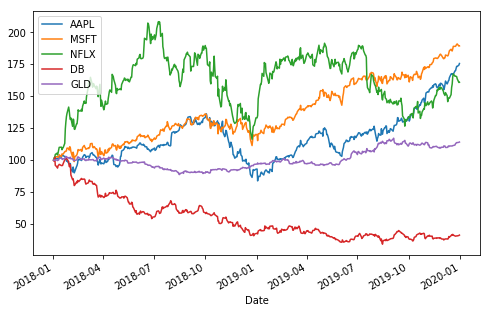

In [12]:
(data / data.iloc[0]*100).plot(figsize=(8,5))

In [13]:
# 로그수익률
rets = np.log(data/data.shift(1))
rets.mean()*252

AAPL    0.282721
MSFT    0.320657
NFLX    0.238829
DB     -0.442936
GLD     0.066580
dtype: float64

In [14]:
# 공분산 행렬
rets.cov()*252

,AAPL,MSFT,NFLX,DB,GLD
AAPL,0.076300,0.044668,0.053522,0.035788,-0.004018
MSFT,0.044668,0.059527,0.060418,0.029950,-0.002715
NFLX,0.053522,0.060418,0.166652,0.043257,-0.002204
DB,0.035788,0.029950,0.043257,0.129813,-0.003648
GLD,-0.004018,-0.002715,-0.002204,-0.003648,0.011501


# 기초이론
여기서는 투자자가 매도 포지션을 가질 수 없고 매수 포지션만 가진다고 가정

In [15]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([0.12308358, 0.02359828, 0.23024302, 0.13514051, 0.48793461])

In [16]:
np.sum(rets.mean() * weights) *252

0.0699821743646423

In [17]:
# 포트폴리오 분산의 기댓값
np.dot(weights.T, np.dot(rets.cov()*252, weights))

0.021634014660324354

In [18]:
# 포트폴리오 표준편차(변동성)의 기댓값
np.sqrt(np.dot(weights.T, np.dot(rets.cov()*252, weights)))

0.14708505926954088

In [21]:
# 몬테카를로 시뮬레이션 결과
prets = []
pvols = []
for p in range(2500) : 
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean()* weights)*252)
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov()*252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

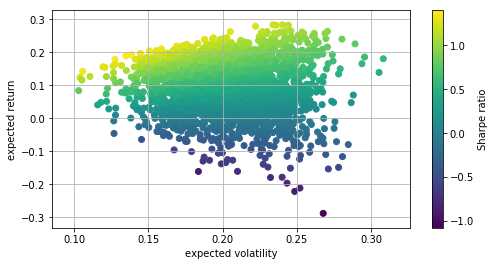

In [22]:
# 무작위 포트폴리오 그래프
plt.figure(figsize=(8,4))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# 포트폴리오 최적화
일단 앞으로의 편의를 위해 주식 비중에 대한 벡터/배열을 입력하여 주요 포트폴리오 통계를 출력하는 함수를 만들어본다.

In [23]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) *252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov()*252, weights)))
    return np.array([pret, pvol, pret/pvol])

In [24]:
import scipy.optimize as sco

minimize 함수는 (부)등호 제약 조건과 변수 범위 제약 조건이 있는 일반적인 경우에 대해 최소화 문제를 계산한다. 샤프 지수를 최ㅐㄷ화하려면 샤프 지수의 음수 값을 최소화하면 된다.


In [25]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [26]:
# 제약 조건으로는 모든 입력 변수의 합이 1이 되어야 한다.
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) -1})

In [27]:
# 주식 비중에 해당하는 입력값의 범위는 0과 1사이로 제한한다.
bnds = tuple((0,1) for x in range(noa))

In [29]:
# 초깃값 리스트는 균등하게 분배
noa * [1./noa,]

[0.2, 0.2, 0.2, 0.2, 0.2]

In [30]:
%%time
opts = sco.minimize(min_func_sharpe, noa*[1./noa,], method='SLSQP',bounds=bnds, constraints=cons)

Wall time: 98.2 ms


In [39]:
opts

     fun: 0.00831917568698569
     jac: array([0.01611137, 0.01712054, 0.02036249, 0.0166994 , 0.01660699])
 message: 'Optimization terminated successfully.'
    nfev: 56
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([6.08186320e-02, 1.11886312e-01, 1.08420217e-18, 4.37606311e-02,
       7.83534425e-01])

In [32]:
opts['x'].round(3)

array([0.099, 0.352, 0.   , 0.   , 0.549])

In [33]:
statistics(opts['x']).round(3)

array([0.177, 0.115, 1.543])

변동성을 최소화하는 별도의 함수 정의하기

In [34]:
def min_func_variance(weights):
    return statistics(weights)[1]**2


In [36]:
optv = sco.minimize(min_func_variance, noa*[1./noa,], method='SLSQP',bounds=bnds, constraints=cons)

In [37]:
optv

     fun: 0.00831917568698569
     jac: array([0.01611137, 0.01712054, 0.02036249, 0.0166994 , 0.01660699])
 message: 'Optimization terminated successfully.'
    nfev: 56
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([6.08186320e-02, 1.11886312e-01, 1.08420217e-18, 4.37606311e-02,
       7.83534425e-01])

In [38]:
optv['x'].round(3)

array([0.061, 0.112, 0.   , 0.044, 0.784])

# 효율적 투자선
목표 수익률을 고정시키고 그 수익률을 달성하면서 최소의 변동성을 가지는 포트폴리오 비중 계산하기

In [40]:
cons = ({'type':'eq', 'fun': lambda x: statistics(x)[0] -tret},
        {'type':'eq', 'fun': lambda x: np.sum(x) -1})
bnds = tuple((0,1) for x in weights)

In [41]:
def min_func_port(weights):
    return statistics(weights)[1]

In [42]:
%%time
trets = np.linspace(0.0,0.25,50)
tvols = []
for tret in trets:
    cons = ({'type':'eq', 'fun': lambda x: statistics(x)[0] -tret},
        {'type':'eq', 'fun': lambda x: np.sum(x) -1})
    res = sco.minimize(min_func_port, noa*[1./noa,], method='SLSQP',bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

Wall time: 11.3 s


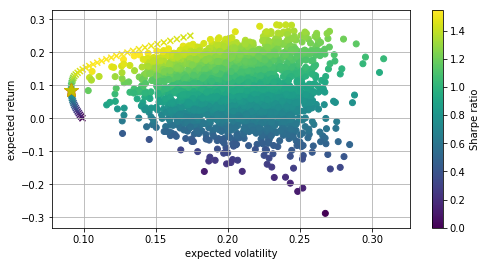

In [43]:
# 무작위 포트폴리오 그래프
plt.figure(figsize=(8,4))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
# 효율적 투자선
plt.scatter(tvols, trets, c=trets/tvols, marker='x')
# 최대 샤프 지수를 가진 포트폴리오
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize=15.0)
# 최소 분산 포트폴리오
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# 자본시장선
무위험 자산을 같이 고려하면 투자자가 선택할 수 있는 효율적 투자 기회 집합은 크게 늘어난다

In [45]:
import scipy.interpolate as sci

In [49]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

In [50]:
tck = sci.splrep(evols, erets)

In [51]:
#효율적 투자선을 표현하는 연속 미분 가능한 함수(스플라인 근사)와 이를 미분한 일차 도함수
def f(x):
    return sci.splev(x, tck, der=0)
def df(x):
    return sci.splev(x, tck, der=1)

효율적 투자선이나 그 도함수에 대한 닫힌 형태의 수식이 없기 때문에 입력변수가 주어지면 세개의 값을 모두 출력하는 파이썬 함수 정의

In [53]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1]*p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [54]:
opt = sco.fsolve(equations, [0.01,0.5,0.15])

In [55]:
opt

array([0.01      , 1.45765348, 0.11899876])

In [56]:
np.round(equations(opt), 6)

array([ 0., -0., -0.])

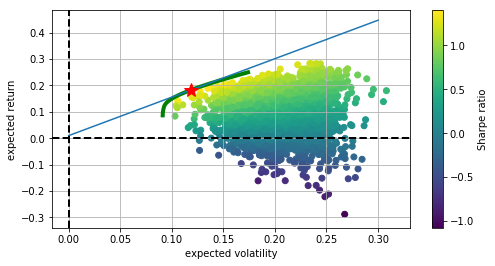

In [59]:
# 무작위 포트폴리오 그래프
plt.figure(figsize=(8,4))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
# 효율적 투자선
plt.plot(evols, erets, 'g', lw=4.0)
# 자본시장선
cx = np.linspace(0.0,0.3)
plt.plot(cx, opt[0]+opt[1]*cx, lw=1.5)
plt.plot(opt[2], f(opt[2]),'r*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--',lw=2.0)
plt.axvline(0, color='k', ls='--',lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [60]:
cons = ({'type':'eq', 'fun': lambda x: statistics(x)[0] -f(opt[2])},
        {'type':'eq', 'fun': lambda x: np.sum(x) -1})
res = sco.minimize(min_func_port, noa*[1./noa,], method='SLSQP',bounds=bnds, constraints=cons)

In [61]:
res['x'].round(3)

array([0.1  , 0.375, 0.   , 0.   , 0.525])